In [29]:
from pathlib import Path
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep 
hep.style.use(hep.style.ATLAS)
# plt.style.use(hep.style.ATLAS)
import awkward as ak
from tqdm import tqdm 

import joblib
import vector
import numba as nb
# import ROOT

In [2]:
ssWW_Ntuple_folder_path = Path("/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/")
fit_input_folder_path = Path("/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/")

# Prepare

In [8]:
Mjj_bin_edges = np.array([ 500.,  850., 1450., 2100., 2550., 3000.], dtype=float)
MT_bin_edges = np.array([0, 100, 180, 230, 280, 350, 500, 800, 1500], dtype=float)

mass_points1 = np.linspace(200, 550, int((550 - 200) / 25 + 1), dtype=int)
mass_points2 = np.linspace(600, 1000, int((1000 - 600) / 100 + 1), dtype=int)
mass_points3 = np.array([1500, 2000, 3000], dtype=int)
mass_points = np.concatenate([mass_points1, mass_points2, mass_points3])

period_labels = np.array(['a', 'd', 'e'])
dsid_map = dict.fromkeys(mass_points)
dsid_start = 511727 
for mass_idx, masss_point in enumerate(mass_points):
    dsid_map[masss_point] = dsid_start + mass_idx

ttree_prefix = 'HWWTree_'
ttree_channels = ['em', 'me', 'ee', 'mm']

## Signal

In [3]:
sorted(ssWW_Ntuple_folder_path.iterdir())

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_WZ'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Wgamma'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_ZZ'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Zgamma'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_fakes'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/data'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGH7'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGPy8')]

In [13]:
higgspp_folder_path = ssWW_Ntuple_folder_path / "higgspp"
sorted(higgspp_folder_path.iterdir())

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511727_full_run2_sig_X_mc16a_EWK_GM_H5_m200.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511727_full_run2_sig_X_mc16d_EWK_GM_H5_m200.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511727_full_run2_sig_X_mc16e_EWK_GM_H5_m200.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511728_full_run2_sig_X_mc16a_EWK_GM_H5_m225.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511728_full_run2_sig_X_mc16d_EWK_GM_H5_m225.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511728_full_run2_sig_X_mc16e_EWK_GM_H5_m225.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511729_full_run2

In [9]:
## For the root files at different mass points, convert it to a pandas dataframe and save it as a pickle file
## Need to store some additional event information, like the period, channel etc 

In [89]:
higgspp = []
for mass_point in tqdm(mass_points):

    for period_label in period_labels:
        sig_m_period_path = higgspp_folder_path / f"{dsid_map[mass_point]}_full_run2_sig_X_mc16{period_label}_EWK_GM_H5_m{mass_point}.root"
        # print(sig_m_path.name)
        sig_m_period = uproot.open(sig_m_period_path) if sig_m_period_path.exists() else print(f"{sig_m_period_path} does not exist")
        for ttree_channel in ttree_channels:
            ttree_name = ttree_prefix + ttree_channel
            df_sig_m_period_channel = sig_m_period[ttree_name].arrays(library="pd")
            # change the unit of mjj from MeV to GeV 
            # df_sig_m_period_channel['mjj'] = df_sig_m_period_channel['mjj'] / 1000
            # add a new column to store the mass point
            df_sig_m_period_channel['file_identifer'] = f"signal_m{mass_point}"
            # add a new column to store the period label
            df_sig_m_period_channel['period_label'] = period_label
            # add a new column to store the channel
            df_sig_m_period_channel['channel'] = ttree_channel
            # add a new column to store the dsid
            # df_sig_m_period_channel['dsid'] = dsid_map[mass_point]

            higgspp.append(df_sig_m_period_channel)

assert len(higgspp) == len(mass_points) * len(period_labels) * len(ttree_channels)
df_higgspp = pd.concat(higgspp, ignore_index=True)

100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


In [90]:
lep0_4vec = vector.array({
    "px": df_higgspp["lep0_px"],
    "py": df_higgspp["lep0_py"],
    "pz": df_higgspp["lep0_pz"],
    "E": df_higgspp["lep0_e"],
})

lep1_4vec = vector.array({
    "px": df_higgspp["lep1_px"],
    "py": df_higgspp["lep1_py"],
    "pz": df_higgspp["lep1_pz"],
    "E": df_higgspp["lep1_e"],
})

In [91]:
df_higgspp['lep0_eta'] = lep0_4vec.eta
df_higgspp['lep1_eta'] = lep1_4vec.eta

df_higgspp['lep0_phi'] = lep0_4vec.phi
df_higgspp['lep1_phi'] = lep1_4vec.phi

df_higgspp['target'] = 1 

In [92]:
df_higgspp.head()

,runNumber,eventNumber,mjj,dyjj,met,lep0_pt,lep1_pt,jet0_pt,jet1_pt,lep0_px,...,chFlipWeight,weight,file_identifer,period_label,channel,lep0_eta,lep1_eta,lep0_phi,lep1_phi,target
0,284500,14601,801949.875,5.100585,64270.414062,78535.625000,47092.480469,72193.867188,54515.601562,-13771.283203,...,0.999986,0.067403,signal_m200,a,em,0.685348,1.591141,-1.747058,2.768547,1
1,284500,10422,1446468.125,5.512991,105120.257812,48329.632812,44830.546875,101798.164062,81047.179688,-46049.464844,...,1.000005,0.050500,signal_m200,a,em,0.678817,-0.691944,-2.833193,-1.621876,1
2,284500,14653,700154.750,4.318008,76280.273438,71677.265625,32477.414062,81508.117188,76487.039062,63227.390625,...,0.999986,0.059568,signal_m200,a,em,0.628099,1.639016,0.490469,-1.340614,1
3,284500,10882,528562.000,3.172592,77275.921875,61421.968750,30469.593750,170441.562500,63760.125000,30813.949219,...,0.999923,0.056380,signal_m200,a,em,0.930431,1.964278,-1.045261,2.749825,1
4,284500,14464,2339444.250,6.622375,54202.949219,66543.000000,27943.820312,145741.781250,49700.605469,64896.824219,...,0.999923,0.057285,signal_m200,a,em,-0.883232,-0.640482,0.222896,3.137925,1


In [93]:
df_higgspp.columns

Index(['runNumber', 'eventNumber', 'mjj', 'dyjj', 'met', 'lep0_pt', 'lep1_pt',
       'jet0_pt', 'jet1_pt', 'lep0_px', 'lep0_py', 'lep0_pz', 'lep0_e',
       'lep1_px', 'lep1_py', 'lep1_pz', 'lep1_e', 'nJets', 'MCweight',
       'muonIsoWeight', 'muonTTVAWeight', 'muonRecoWeight',
       'electronIsoWeight', 'electronRecoWeight', 'electronIDWeight',
       'jvtWeight', 'forwardJVTWeight', 'prwWeight', 'eventWeight',
       'triggerWeight', 'bTagWeight', 'chFlipWeight', 'weight',
       'file_identifer', 'period_label', 'channel', 'lep0_eta', 'lep1_eta',
       'lep0_phi', 'lep1_phi', 'target'],
      dtype='object')

In [94]:
joblib.dump(df_higgspp, "signal.pkl")

['signal.pkl']

In [48]:
!ls -alh

total 65M
drwxrws--x+ 2 hrzhao atlas 4.0K May 17 09:52 .
drwxrws--x+ 6 hrzhao atlas 4.0K May 11 12:21 ..
-rw-rw----+ 1 hrzhao atlas 235K May 16 11:54 explore_WW.ipynb
-rw-rw----+ 1 hrzhao atlas  29K May 17 10:03 NNtraining.ipynb
-rw-rw----+ 1 hrzhao atlas 3.5K May 15 11:24 prefityieldshpp.txt
-rw-rw----+ 1 hrzhao atlas  65M May 17 10:04 signal.pkl


## Background

In [50]:
WZ = sorted(ssWW_Ntuple_folder_path.iterdir())[0]

In [52]:
test_file = sorted(WZ.iterdir())[0]

In [53]:
test_file = uproot.open(test_file)

In [55]:
test_file['HWWTree_em'].keys()

['runNumber',
 'eventNumber',
 'mjj',
 'dyjj',
 'met',
 'lep0_pt',
 'lep1_pt',
 'jet0_pt',
 'jet1_pt',
 'lep0_px',
 'lep0_py',
 'lep0_pz',
 'lep0_e',
 'lep1_px',
 'lep1_py',
 'lep1_pz',
 'lep1_e',
 'nJets',
 'MCweight',
 'muonIsoWeight',
 'muonTTVAWeight',
 'muonRecoWeight',
 'electronIsoWeight',
 'electronRecoWeight',
 'electronIDWeight',
 'jvtWeight',
 'forwardJVTWeight',
 'prwWeight',
 'eventWeight',
 'triggerWeight',
 'bTagWeight',
 'chFlipWeight',
 'weight']

In [83]:
files_not_use = ["background_run2_MGH7EG_WZEW", "background_run2_MGPy8EG_WZINT", "background_run2_MGPy8_Zgamma", "background_run2_MGPy8_Wgamma"]
files_not_use = files_not_use + ["signal_run2_500986_LOMGPy8_EW", "signal_run2_500988_LOMGPy8_INT", "signal_run2_500987_LOMGPy8_QCD"]
bkg = []

for folder_path in ssWW_Ntuple_folder_path.iterdir():
    if folder_path.name == 'higgspp':
        continue

    for file_path in folder_path.glob("*.root"):
        if not (file_path.name.startswith("background_run2") or file_path.name.startswith("signal_run2")):
            continue
        
        if file_path.stem in files_not_use:
            continue

        print(file_path.name)

        bkg_period = uproot.open(file_path) if file_path.exists() else print(f"{file_path} does not exist")
        for ttree_channel in ttree_channels:
            ttree_name = ttree_prefix + ttree_channel
            df_bkg_period = bkg_period[ttree_name].arrays(library="pd")

            df_bkg_period['file_identifer'] = file_path.stem
            # add a new column to store the period label
            df_bkg_period['period_label'] = "run2"
            # add a new column to store the channel
            df_bkg_period['channel'] = ttree_channel

            bkg.append(df_bkg_period)

df_bkg = pd.concat(bkg, ignore_index=True)

background_run2_SHERPA_ZZ.root
background_run2_MGPy8EG_WZEW.root
background_run2_SHERPA222_WZQCD.root
signal_run2_500989_LOMGH7_EW.root
signal_run2_500991_LOMGH7_INT.root
signal_run2_500990_LOMGH7_QCD.root
background_run2_SHERPA2211_Zgamma.root
background_run2_SHERPA2211_Wgamma.root
background_run2_ddFakes.root


In [95]:
bkg_lep0_4vec = vector.array({
    "px": df_bkg["lep0_px"],
    "py": df_bkg["lep0_py"],
    "pz": df_bkg["lep0_pz"],
    "E": df_bkg["lep0_e"],
})

bkg_lep1_4vec = vector.array({
    "px": df_bkg["lep1_px"],
    "py": df_bkg["lep1_py"],
    "pz": df_bkg["lep1_pz"],
    "E": df_bkg["lep1_e"],
})

df_bkg['lep0_eta'] = bkg_lep0_4vec.eta
df_bkg['lep1_eta'] = bkg_lep1_4vec.eta

df_bkg['lep0_phi'] = bkg_lep0_4vec.phi
df_bkg['lep1_phi'] = bkg_lep1_4vec.phi

df_bkg['target'] = 0 


In [96]:
df_bkg.groupby('file_identifer').sum(numeric_only=True)

,runNumber,eventNumber,mjj,dyjj,met,lep0_pt,lep1_pt,jet0_pt,jet1_pt,lep0_px,...,eventWeight,triggerWeight,bTagWeight,chFlipWeight,weight,lep0_eta,lep1_eta,lep0_phi,lep1_phi,target
file_identifer,,,,,,,,,,,,,,,,,,,,,
background_run2_MGPy8EG_WZEW,2485765000,6253146485,1.084079e+10,35462.757812,8.265911e+08,9.649669e+08,4.776067e+08,1.737782e+09,9.201450e+08,1041387.5,...,2.923141e-02,8196.129883,8243.820312,8273.436523,14.951426,-68.882057,-152.092178,6.251157,84.253258,0
background_run2_SHERPA2211_Wgamma,165680000,27050765103,5.412646e+08,1935.693604,8.262498e+07,1.149059e+08,4.063242e+07,1.719130e+08,6.087071e+07,-13723854.0,...,2.186996e+08,549.046509,546.977966,552.036316,9.693901,-8.617013,-11.923738,4.629329,0.308621,0
background_run2_SHERPA2211_Zgamma,6958000,375020159,1.915157e+07,83.481361,4.335998e+07,4.483438e+07,1.554741e+06,5.979138e+06,2.140765e+06,28871934.0,...,2.851310e+06,22.847031,22.743439,23.000000,0.556548,3.948245,4.950361,12.238044,3.763445,0
background_run2_SHERPA222_WZQCD,8354367000,1059734991797,2.574598e+10,102617.906250,2.795189e+09,3.254775e+09,1.573630e+09,6.007457e+09,2.976359e+09,28296180.0,...,3.402357e+03,27563.935547,27608.953125,27800.986328,82.753011,55.193386,133.418655,190.668839,-539.267944,0
background_run2_SHERPA_ZZ,863636500,105641968738,2.816705e+09,11271.513672,2.070341e+08,2.775048e+08,1.422203e+08,5.262961e+08,3.072145e+08,4150881.5,...,1.329020e+04,2859.726807,2864.567871,2880.015869,2.509481,-85.018509,3.021948,-66.613640,41.213062,0
background_run2_ddFakes,72673947,340175056071,2.166709e+08,885.117859,2.168893e+07,2.429885e+07,1.062523e+07,3.759302e+07,2.136892e+07,2595215.0,...,2.170000e+02,217.000000,217.000000,217.000000,66.252239,-19.661736,-19.955822,-25.413239,0.903293,0
signal_run2_500989_LOMGH7_EW,60505043500,401609254807,2.903436e+11,872342.687500,2.314249e+10,2.487352e+10,1.227435e+10,4.526428e+10,2.394904e+10,47639444.0,...,6.879555e+03,198930.593750,200121.250000,201508.437500,234.902752,-376.073975,-15.108148,-315.601257,-540.710815,0
signal_run2_500990_LOMGH7_QCD,7614174500,50279964426,2.276992e+10,81682.093750,3.099220e+09,3.103691e+09,1.495290e+09,6.464312e+09,3.431518e+09,-5923694.5,...,6.844889e+02,25123.675781,25091.558594,25375.912109,24.049193,-21.855574,5.406155,71.473213,213.134354,0
signal_run2_500991_LOMGH7_INT,23962657000,158813430041,8.261957e+10,266582.125000,1.022674e+10,1.042733e+10,5.032350e+09,2.180388e+10,1.158541e+10,13860665.0,...,2.230506e+02,78792.421875,78941.492188,79814.390625,7.572280,165.412628,-295.984406,752.990356,629.716248,0


In [98]:
df_bkg.head()

,runNumber,eventNumber,mjj,dyjj,met,lep0_pt,lep1_pt,jet0_pt,jet1_pt,lep0_px,...,chFlipWeight,weight,file_identifer,period_label,channel,lep0_eta,lep1_eta,lep0_phi,lep1_phi,target
0,284500,3978202,8.132535e+05,3.426486,58833.875000,69981.968750,53140.550781,146455.890625,138819.687500,51203.800781,...,1.000117,0.000629,background_run2_SHERPA_ZZ,run2,em,1.990464,1.718411,-0.750026,1.507005,0
1,284500,4156341,1.754824e+06,4.406075,82061.265625,37708.855469,33957.457031,247015.828125,147645.343750,-26557.912109,...,1.000060,0.000876,background_run2_SHERPA_ZZ,run2,em,2.292020,1.348897,-2.352217,1.442176,0
2,284500,3585202,1.721305e+06,3.130399,94584.710938,69996.156250,42288.261719,490617.968750,241905.625000,-39856.824219,...,1.000117,0.000660,background_run2_SHERPA_ZZ,run2,em,-1.835316,1.770463,2.176590,2.264817,0
3,284500,5259986,9.122511e+05,5.029059,69000.054688,34057.214844,31802.187500,78706.437500,67876.468750,-27417.648438,...,1.000060,0.004939,background_run2_SHERPA_ZZ,run2,em,-1.914827,-0.988383,2.506551,-0.434667,0
4,284500,5810559,7.922457e+05,4.783946,70476.507812,60201.320312,28479.134766,95677.351562,53974.089844,57599.632812,...,0.999744,0.000410,background_run2_SHERPA_ZZ,run2,em,-2.427609,-1.934541,-0.295064,2.510034,0


In [99]:
joblib.dump(df_bkg, "bkg.pkl")

['bkg.pkl']

In [100]:
!ls -alh

total 117M
drwxrws--x+ 2 hrzhao atlas 4.0K May 17 10:32 .
drwxrws--x+ 6 hrzhao atlas 4.0K May 11 12:21 ..
-rw-rw----+ 1 hrzhao atlas  57M May 17 10:32 bkg.pkl
-rw-rw----+ 1 hrzhao atlas 235K May 16 11:54 explore_WW.ipynb
-rw-rw----+ 1 hrzhao atlas  50K May 17 10:30 NNtraining.ipynb
-rw-rw----+ 1 hrzhao atlas 3.5K May 15 11:24 prefityieldshpp.txt
-rw-rw----+ 1 hrzhao atlas  61M May 17 10:31 signal.pkl


# Distribution

In [101]:
df_signal = joblib.load("signal.pkl")
df_bkg = joblib.load("bkg.pkl") 

In [103]:
df_signal.columns

Index(['runNumber', 'eventNumber', 'mjj', 'dyjj', 'met', 'lep0_pt', 'lep1_pt',
       'jet0_pt', 'jet1_pt', 'lep0_px', 'lep0_py', 'lep0_pz', 'lep0_e',
       'lep1_px', 'lep1_py', 'lep1_pz', 'lep1_e', 'nJets', 'MCweight',
       'muonIsoWeight', 'muonTTVAWeight', 'muonRecoWeight',
       'electronIsoWeight', 'electronRecoWeight', 'electronIDWeight',
       'jvtWeight', 'forwardJVTWeight', 'prwWeight', 'eventWeight',
       'triggerWeight', 'bTagWeight', 'chFlipWeight', 'weight',
       'file_identifer', 'period_label', 'channel', 'lep0_eta', 'lep1_eta',
       'lep0_phi', 'lep1_phi', 'target'],
      dtype='object')

In [114]:
features = df_signal.columns[2:18].tolist() + df_signal.columns[-5:-1].tolist() 

In [121]:
features

['mjj',
 'dyjj',
 'met',
 'lep0_pt',
 'lep1_pt',
 'jet0_pt',
 'jet1_pt',
 'lep0_px',
 'lep0_py',
 'lep0_pz',
 'lep0_e',
 'lep1_px',
 'lep1_py',
 'lep1_pz',
 'lep1_e',
 'nJets',
 'lep0_eta',
 'lep1_eta',
 'lep0_phi',
 'lep1_phi']

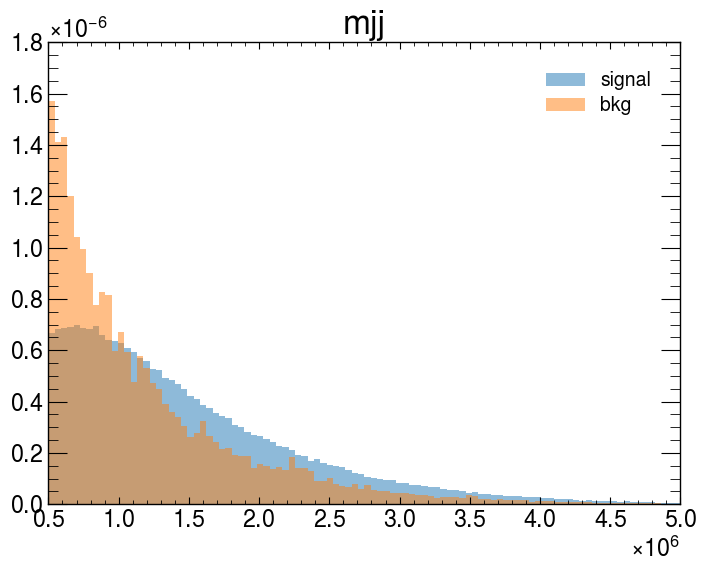

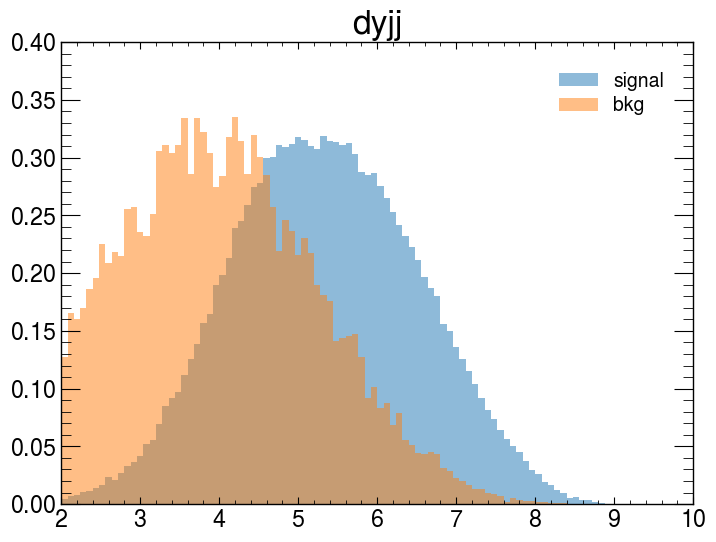

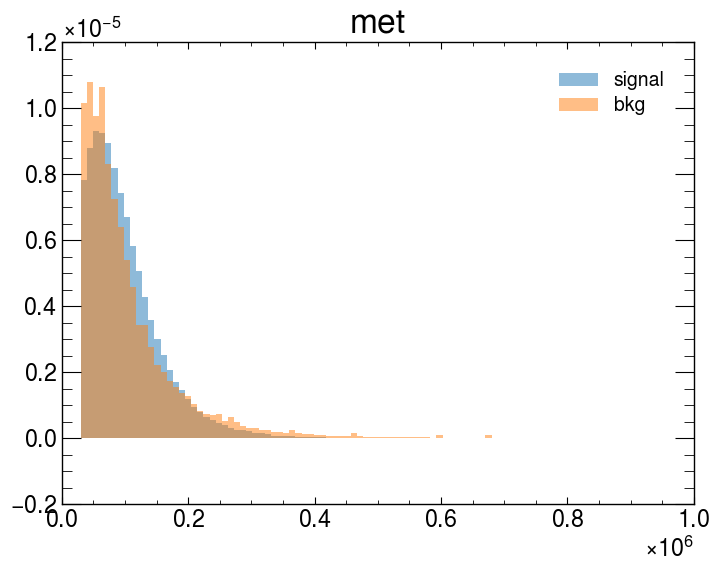

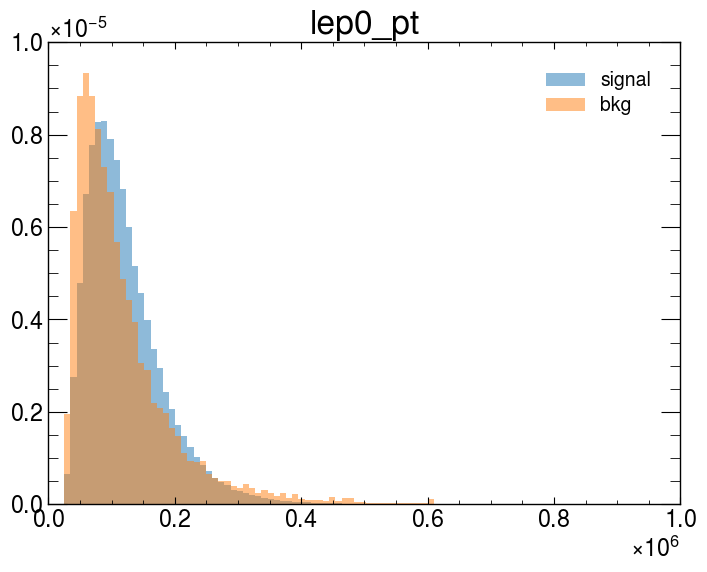

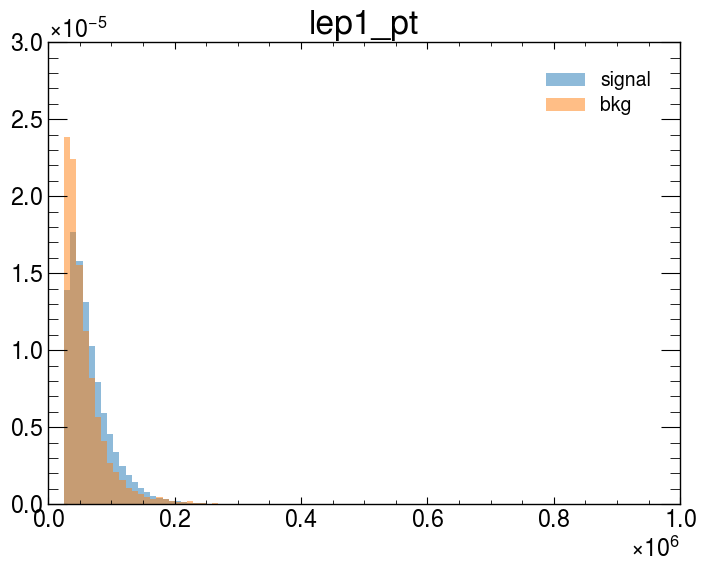

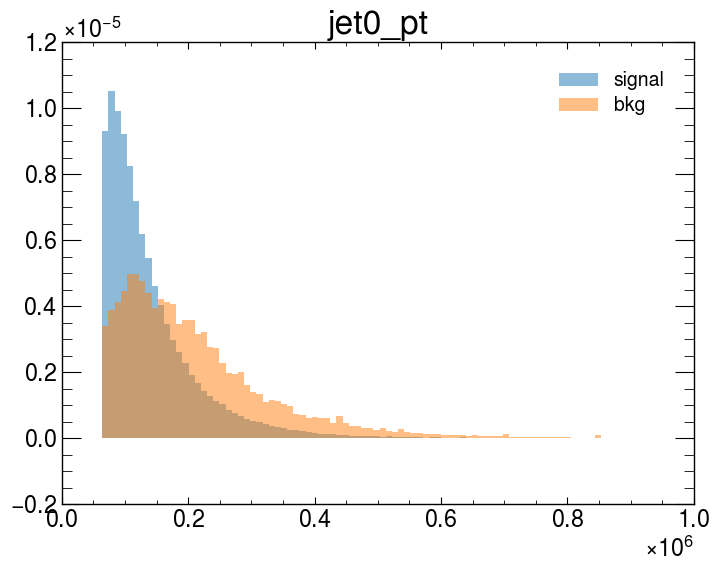

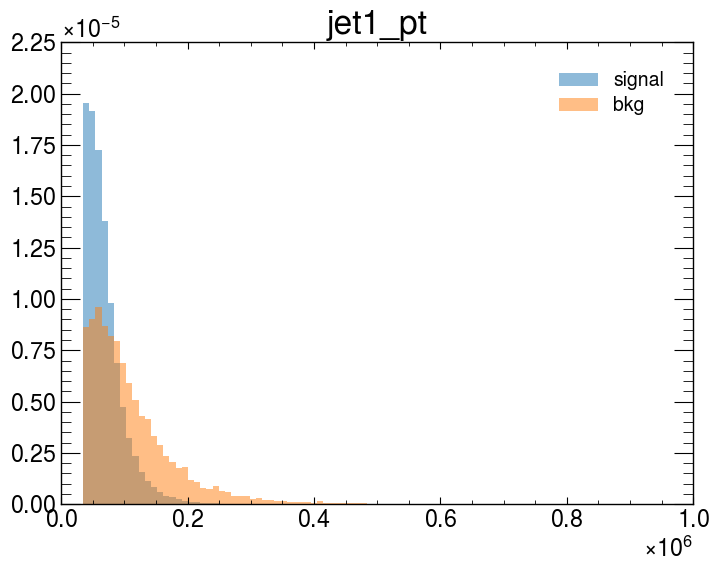

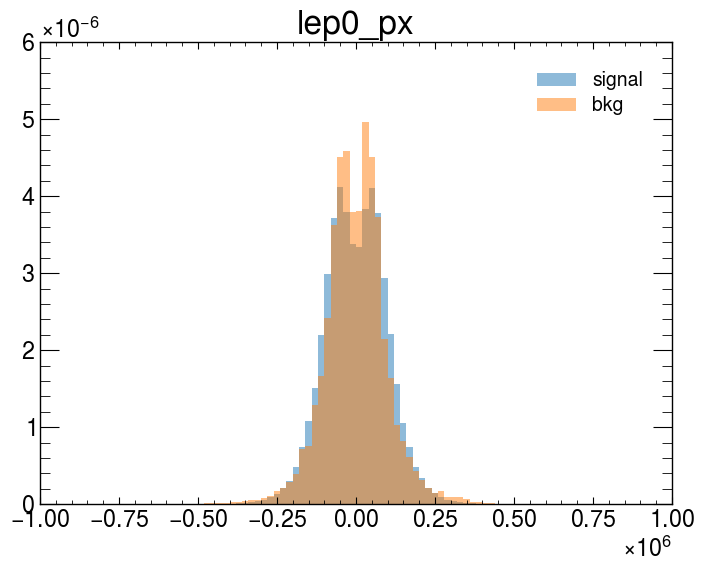

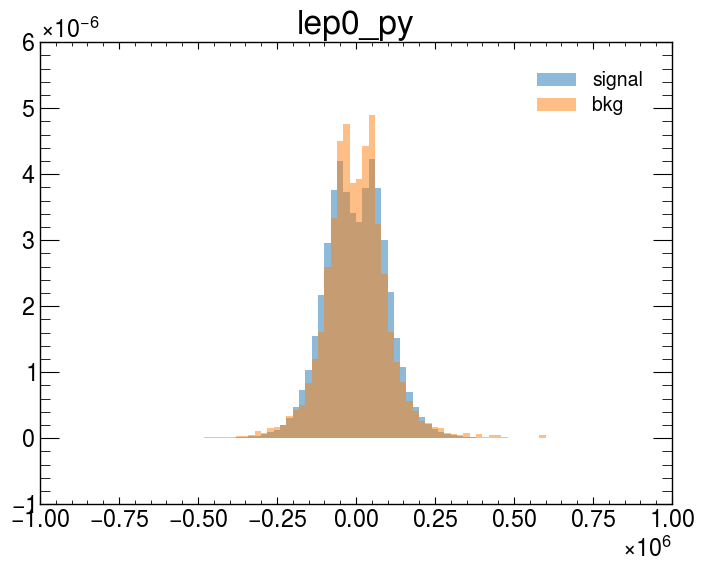

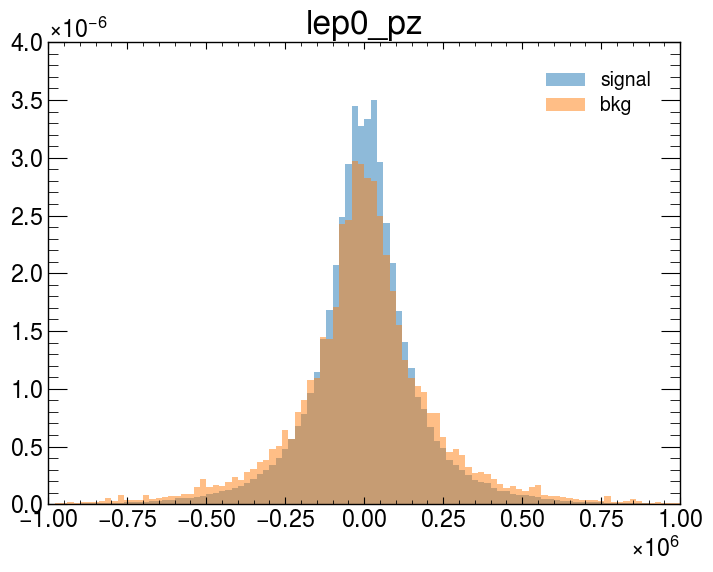

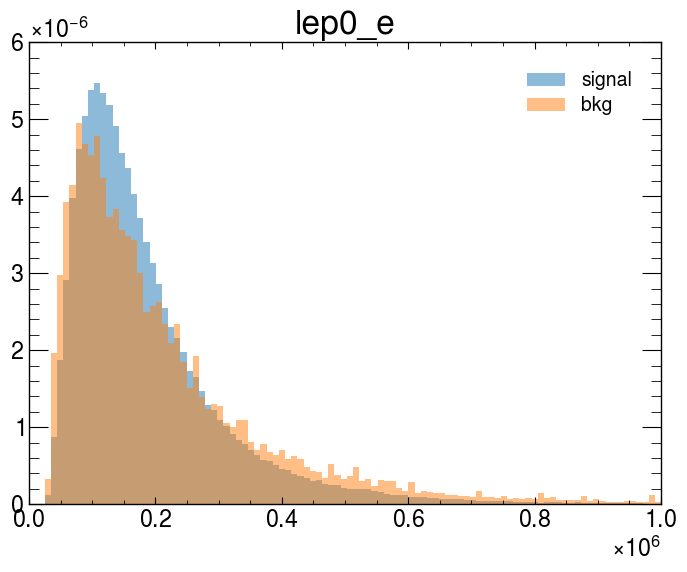

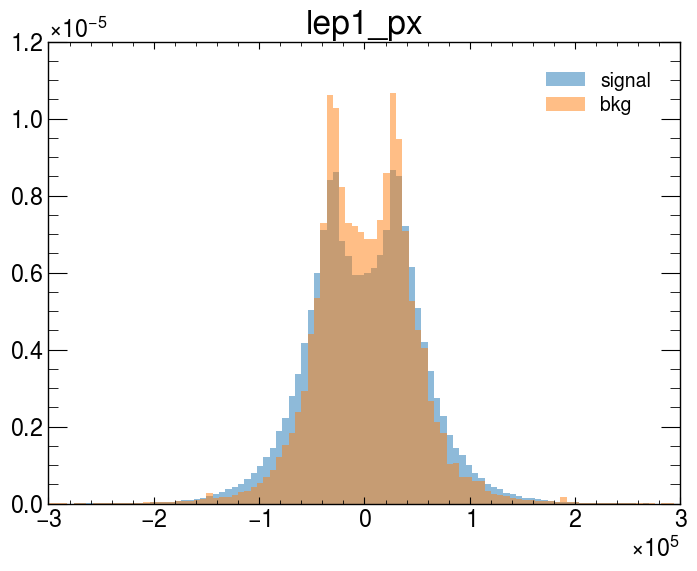

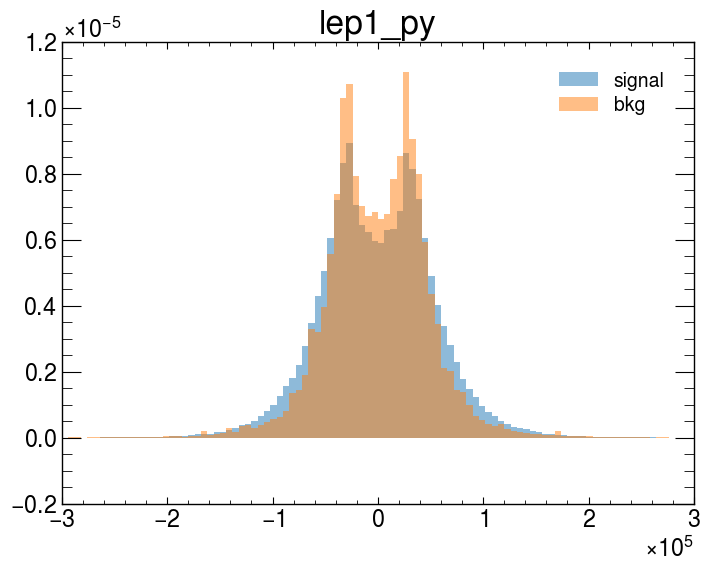

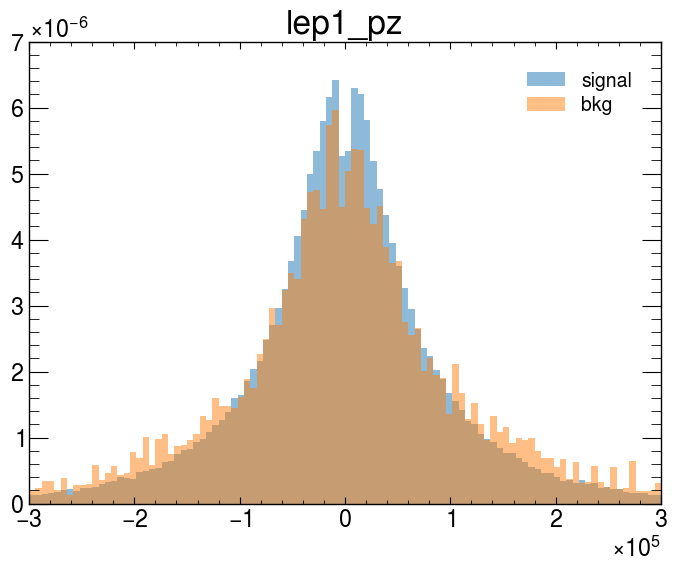

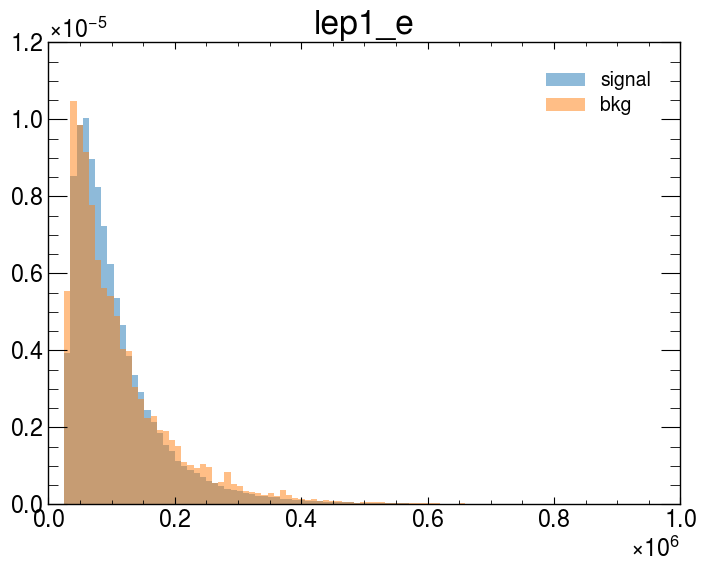

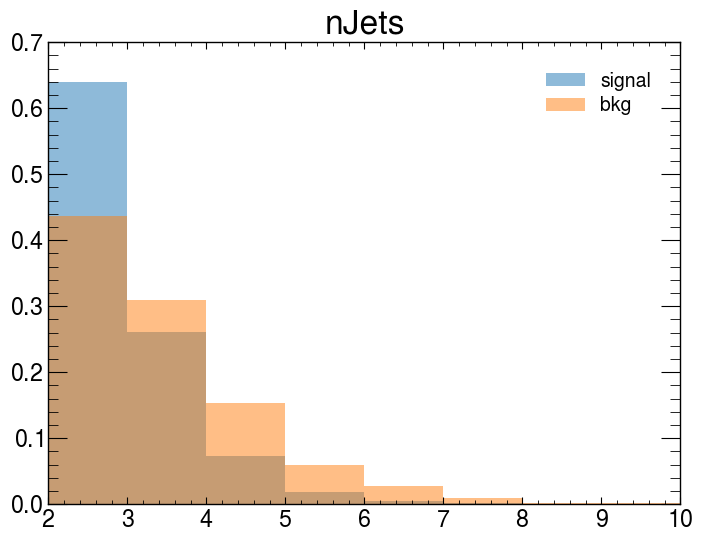

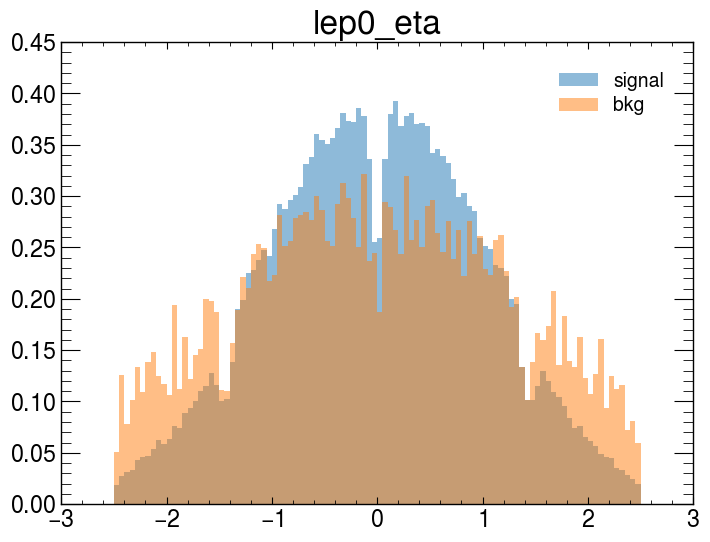

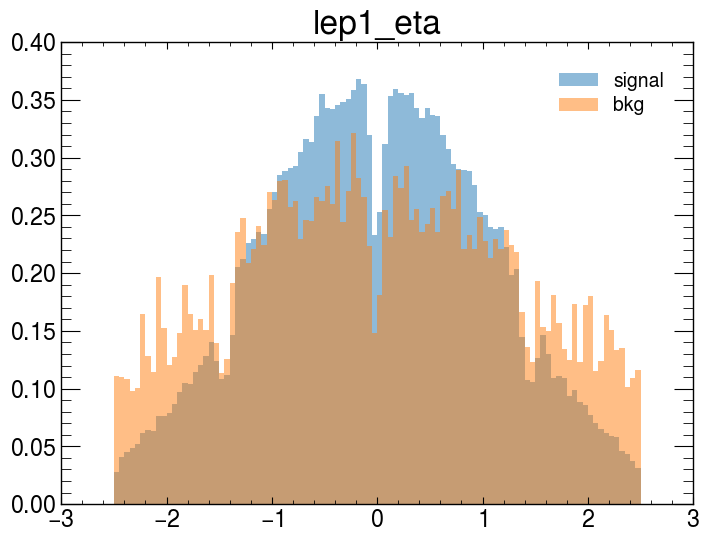

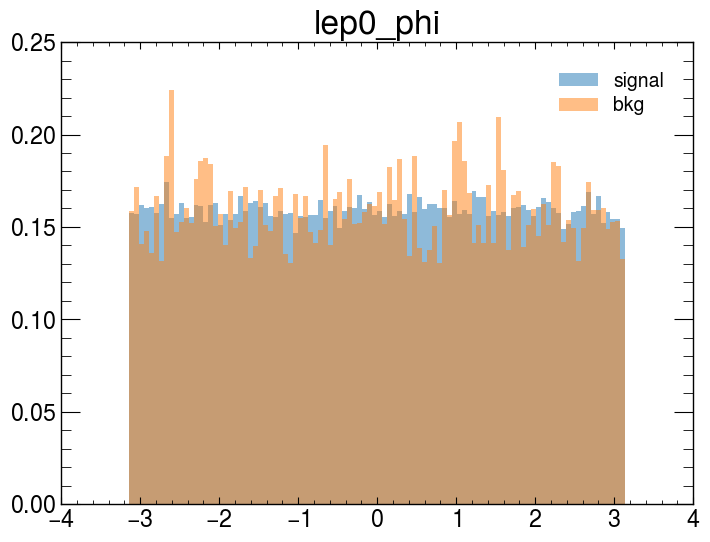

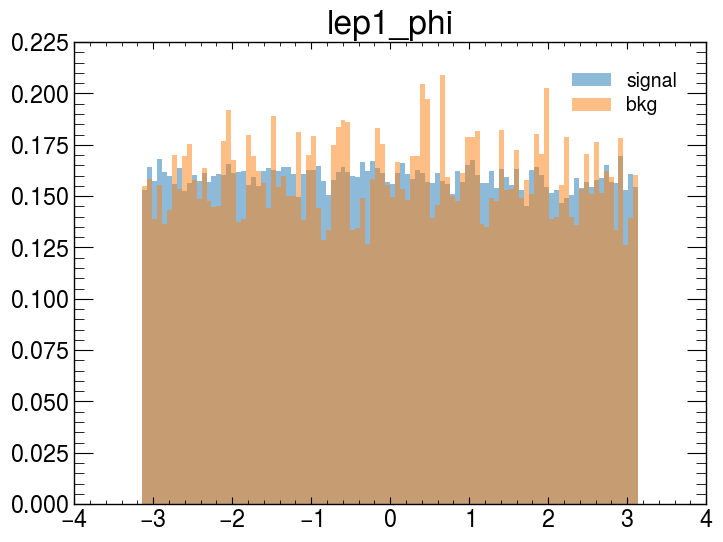

In [125]:
bin_edges_maps = {
    "mjj": np.linspace(500*1e3, 5000*1e3, 101),
    "dyjj": np.linspace(2, 10, 101),
    "met": np.linspace(30*1e3, 1000*1e3, 101),
    "lep0_pt": np.linspace(25*1e3, 1*1e6, 101),
    "lep1_pt": np.linspace(25*1e3, 1*1e6, 101),
    "jet0_pt": np.linspace(25*1e3, 1*1e6, 101),
    "jet1_pt": np.linspace(25*1e3, 1*1e6, 101),
    "lep0_px": np.linspace(-1*1e6, 1*1e6, 101),
    "lep0_py": np.linspace(-1*1e6, 1*1e6, 101),
    "lep0_pz": np.linspace(-1*1e6, 1*1e6, 101),
    "lep0_e": np.linspace(25*1e3, 1*1e6, 101),
    "lep1_px": np.linspace(-0.3*1e6, 0.3*1e6, 101),
    "lep1_py": np.linspace(-0.3*1e6, 0.3*1e6, 101),
    "lep1_pz": np.linspace(-0.3*1e6, 0.3*1e6, 101),
    "lep1_e": np.linspace(25*1e3, 1*1e6, 101),
    "nJets": np.linspace(2, 10, 9),
    "lep0_eta": np.linspace(-2.5, 2.5, 101),
    "lep1_eta": np.linspace(-2.5, 2.5, 101),
    "lep0_phi": np.linspace(-np.pi, np.pi, 101),
    "lep1_phi": np.linspace(-np.pi, np.pi, 101),
}

for feature in features:
    bin_edge = bin_edges_maps[feature]
    fig, ax = plt.subplots()
    ax.hist(df_signal[feature], bins=bin_edge, weights=df_signal["weight"], density = True, label="signal", alpha=0.5)
    ax.hist(df_bkg[feature], bins=bin_edge, weights=df_bkg["weight"], density = True, label="bkg", alpha=0.5)
    ax.legend()
    ax.set_title(feature)
    plt.show()
    